In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from imblearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_licitaciones_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
0,32500000,32000000,32500000.0,NaN,NaN,Adquisición de repuestos para el ILS AMS 2100,adquisición repuesto
1,65310000,65000000,65300000.0,65310000.0,NaN,Suministro de energía eléctrica en el Centro d...,suministrar energía eléctrico centrar conserva...
2,92112000,92000000,92100000.0,92110000.0,92112000.0,"Servicio de duplicado de copias de películas, ...",servicio duplicar copiar película tráiler vide...
3,9122110,9000000,9100000.0,9120000.0,9122000.0,Gas Licuado Propano 2013/2014,licuar propano
4,75000000,75000000,NaN,NaN,NaN,Servicio de vigilancia del Centro Cultural de ...,servicio vigilancia centrar cultural españa mé...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387194 entries, 0 to 387193
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_cpv        387194 non-null  int64  
 1   id_division   387194 non-null  int64  
 2   id_grupo      344341 non-null  float64
 3   id_clase      282283 non-null  float64
 4   id_categoria  193738 non-null  float64
 5   objeto        387194 non-null  object 
 6   clean_text    387194 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 20.7+ MB


In [ ]:
df.isna().sum()

id_cpv               0
id_division          0
id_grupo         42853
id_clase        104911
id_categoria    193456
objeto               0
clean_text           0
dtype: int64

In [ ]:
df.groupby(['id_division']).count()['objeto']

id_division
3000000      3209
9000000      7625
14000000     1009
15000000     4085
16000000      572
18000000     3762
19000000      526
22000000     2710
24000000     2344
30000000     9438
31000000     5062
32000000     3944
33000000    20280
34000000    17050
35000000     5019
37000000     1466
38000000     6610
39000000     6629
41000000      151
42000000     5445
43000000      750
44000000     8228
45000000    65265
48000000     8038
50000000    29686
51000000      897
55000000     9723
60000000     8086
63000000     3208
64000000     3330
65000000      627
66000000     6733
70000000     3343
71000000    20358
72000000    19244
73000000     2101
75000000     1586
76000000       39
77000000     3693
79000000    26186
80000000     6814
85000000    17495
90000000    15482
92000000    14354
98000000     4992
Name: objeto, dtype: int64

In [ ]:
# Let's do the train-split.
X = df['objeto'] # Text
Y = df['id_division'] # Labels

In [ ]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/1000000.0)))

In [ ]:
# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
#La proporcion de training and testing
print(X_train.shape)
print(X_test.shape)

(309755,)
(77439,)


In [ ]:
y_train.groupby(y_train).size()

id_division
14      807
15     3268
16      458
18     3010
19      421
22     2168
24     1875
3      2567
30     7550
31     4050
32     3155
33    16224
34    13640
35     4015
37     1173
38     5288
39     5303
41      121
42     4356
43      600
44     6582
45    52212
48     6430
50    23749
51      718
55     7778
60     6469
63     2567
64     2664
65      502
66     5386
70     2674
71    16286
72    15395
73     1681
75     1269
76       31
77     2954
79    20949
80     5451
85    13996
9      6100
90    12386
92    11483
98     3994
Name: id_division, dtype: int64

In [ ]:
y_test.groupby(y_test).size()

id_division
14      202
15      817
16      114
18      752
19      105
22      542
24      469
3       642
30     1888
31     1012
32      789
33     4056
34     3410
35     1004
37      293
38     1322
39     1326
41       30
42     1089
43      150
44     1646
45    13053
48     1608
50     5937
51      179
55     1945
60     1617
63      641
64      666
65      125
66     1347
70      669
71     4072
72     3849
73      420
75      317
76        8
77      739
79     5237
80     1363
85     3499
9      1525
90     3096
92     2871
98      998
Name: id_division, dtype: int64

In [ ]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [ ]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##MultinomialNB

In [ ]:
#Model and hyperparameters
parametersMNB = { 
                 'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
                 'MNB__alpha':[0, 0.5, 1.0]
                 }
modelMNB = MultinomialNB()

In [ ]:
#Model
clfMNB = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                    tokenizer=word_tokenize,
                                    strip_accents='ascii',
                                    max_features=None,
                                    lowercase=True)),
    ('MNB', modelMNB)
])
clf_MNB_GS = GridSearchCV(clfMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(strip_accents='ascii',
                                                        tokenizer=<function word_tokenize at 0x7f2a783d73b0>)),
                                       ('MNB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'MNB__alpha': [0, 0.5, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=3)

In [ ]:
#Model predictions
y_pred = clf_MNB_GS.predict(X_test)

In [ ]:
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'MNB__alpha': 0, 'vectorizer__ngram_range': (1, 3)}

Grid scores on testing set:

0.688 (+/-0.001) for {'MNB__alpha': 0, 'vectorizer__ngram_range': (1, 1)}
0.721 (+/-0.001) for {'MNB__alpha': 0, 'vectorizer__ngram_range': (1, 2)}
0.747 (+/-0.002) for {'MNB__alpha': 0, 'vectorizer__ngram_range': (1, 3)}
0.706 (+/-0.000) for {'MNB__alpha': 0.5, 'vectorizer__ngram_range': (1, 1)}
0.718 (+/-0.001) for {'MNB__alpha': 0.5, 'vectorizer__ngram_range': (1, 2)}
0.729 (+/-0.001) for {'MNB__alpha': 0.5, 'vectorizer__ngram_range': (1, 3)}
0.663 (+/-0.001) for {'MNB__alpha': 1.0, 'vectorizer__ngram_range': (1, 1)}
0.676 (+/-0.001) for {'MNB__alpha': 1.0, 'vectorizer__ngram_range': (1, 2)}
0.691 (+/-0.001) for {'MNB__alpha': 1.0, 'vectorizer__ngram_range': (1, 3)}

best score:  0.7474423286992408

Grid times on testing set:

63.693 seconds (+/-3.981) for {'MNB__alpha': 0, 'vectorizer__ngram_range': (1, 1)}
72.271 seconds (+/-0.540) for {'

<Figure size 432x288 with 0 Axes>

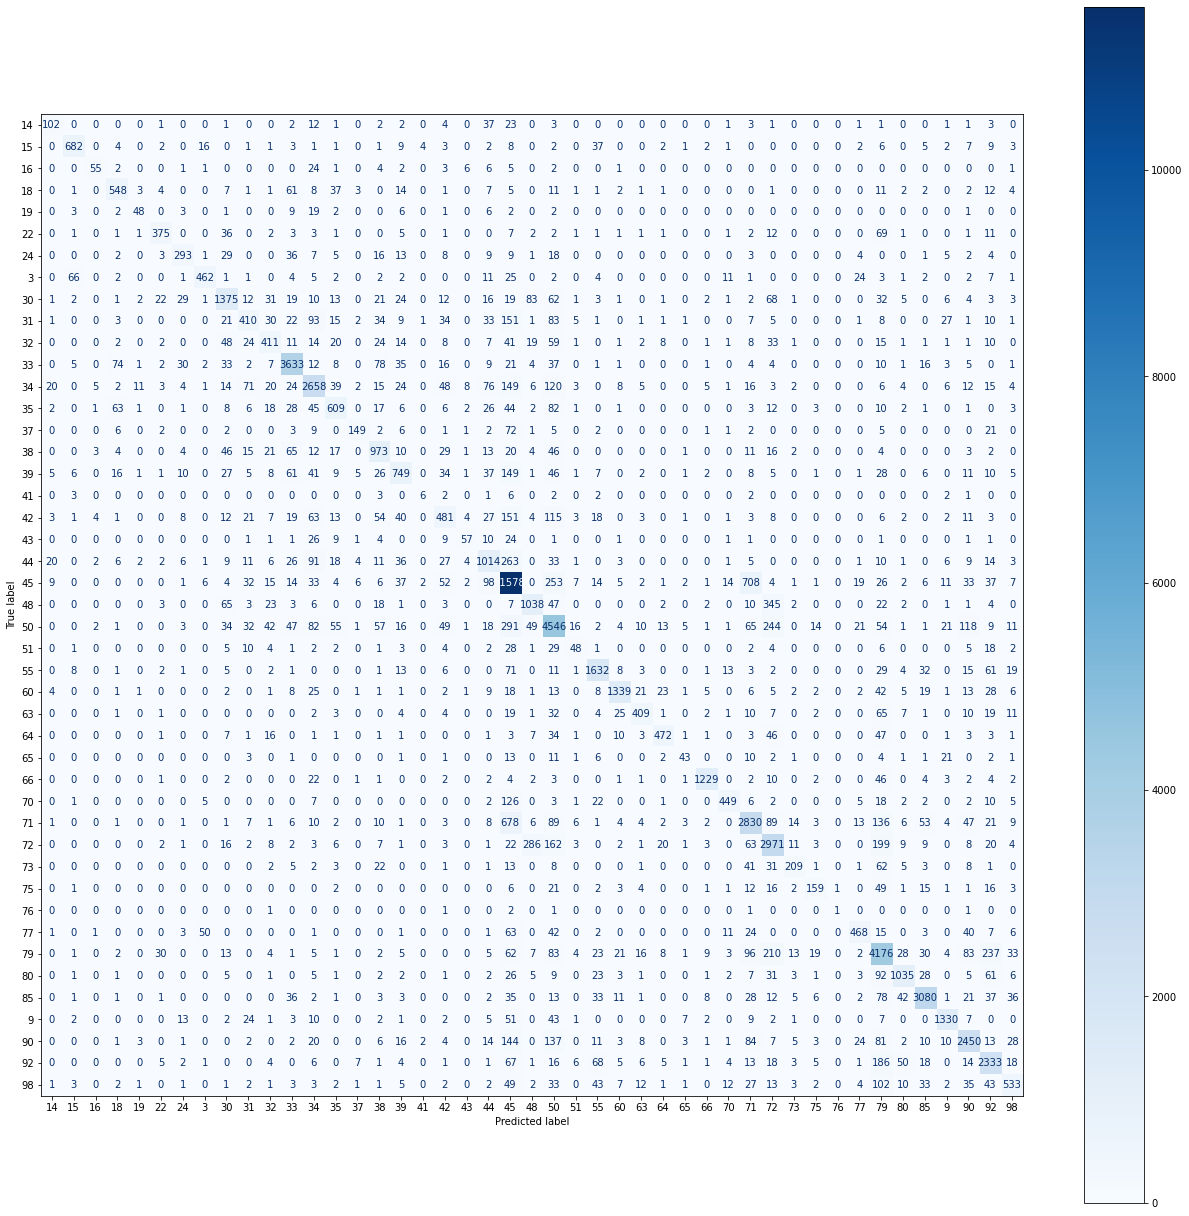

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##LinearSVM

In [ ]:
#Model and hyperparameters
parametersSVM = { 
                 'SVM__max_iter':[300, 500, 1000],
                 'SVM__C':[0.01, 0.1, 1]
                 }
modelSVM = LinearSVC(C=1.0, penalty='l2', 
                  class_weight='balanced', 
                  random_state=42, 
                  max_iter=1000, 
                  verbose=3)

In [ ]:
#Model
clf_SVM = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                    ngram_range = (1,3),
                                    tokenizer=word_tokenize,
                                    strip_accents='ascii',
                                    max_features=None,
                                    lowercase=True)),
    ('SVM', modelSVM)
])

clf_GS_SVM = GridSearchCV(clf_SVM, parametersSVM, cv=2, n_jobs=-1, verbose=3)
clf_GS_SVM.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 3),
                                                        strip_accents='ascii',
                                                        tokenizer=<function word_tokenize at 0x7fe165f863b0>)),
                                       ('SVM',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42,
                                                  verbose=3))]),
             n_jobs=-1,
             param_grid={'SVM__C': [0.01, 0.1, 1],
                         'SVM__max_iter': [300, 500, 1000]},
             verbose=3)

In [ ]:
#Model predictions
y_pred = clf_GS_SVM.predict(X_test)

In [ ]:
#Model performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SVM__C': 0.1, 'SVM__max_iter': 500}

Grid scores on testing set:

0.802 (+/-0.000) for {'SVM__C': 0.01, 'SVM__max_iter': 300}
0.802 (+/-0.000) for {'SVM__C': 0.01, 'SVM__max_iter': 500}
0.802 (+/-0.000) for {'SVM__C': 0.01, 'SVM__max_iter': 1000}
0.815 (+/-0.001) for {'SVM__C': 0.1, 'SVM__max_iter': 300}
0.815 (+/-0.001) for {'SVM__C': 0.1, 'SVM__max_iter': 500}
0.815 (+/-0.001) for {'SVM__C': 0.1, 'SVM__max_iter': 1000}
0.806 (+/-0.001) for {'SVM__C': 1, 'SVM__max_iter': 300}
0.806 (+/-0.001) for {'SVM__C': 1, 'SVM__max_iter': 500}
0.806 (+/-0.001) for {'SVM__C': 1, 'SVM__max_iter': 1000}

best score:  0.8149376100223443

Grid times on testing set:

238.255 seconds (+/-5.167) for {'SVM__C': 0.01, 'SVM__max_iter': 300}
253.154 seconds (+/-21.757) for {'SVM__C': 0.01, 'SVM__max_iter': 500}
242.924 seconds (+/-16.020) for {'SVM__C': 0.01, 'SVM__max_iter': 1000}
370.190 seconds (+/-26.487) for {'SVM__C': 0.1, 'SVM__max_iter':

In [ ]:
#Model performance para SVM__class_weight: ['balanced', None] y  vectorizer__ngram_range: [(1,1),(1,3)]
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SVM__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 3)}

Grid scores on testing set:

0.772 (+/-0.000) for {'SVM__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
0.806 (+/-0.001) for {'SVM__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 3)}
0.779 (+/-0.001) for {'SVM__class_weight': None, 'vectorizer__ngram_range': (1, 1)}
0.805 (+/-0.002) for {'SVM__class_weight': None, 'vectorizer__ngram_range': (1, 3)}

best score:  0.8059950596098572

Grid times on testing set:

224.765 seconds (+/-2.577) for {'SVM__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
473.685 seconds (+/-21.688) for {'SVM__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 3)}
229.840 seconds (+/-11.361) for {'SVM__class_weight': None, 'vectorizer__ngram_range': (1, 1)}
433.898 seconds (+/-51.156) for {'SVM__class_weight': None, 'vectorizer__ngram_range': (1, 3)}
Detailed classification report:

The m

<Figure size 432x288 with 0 Axes>

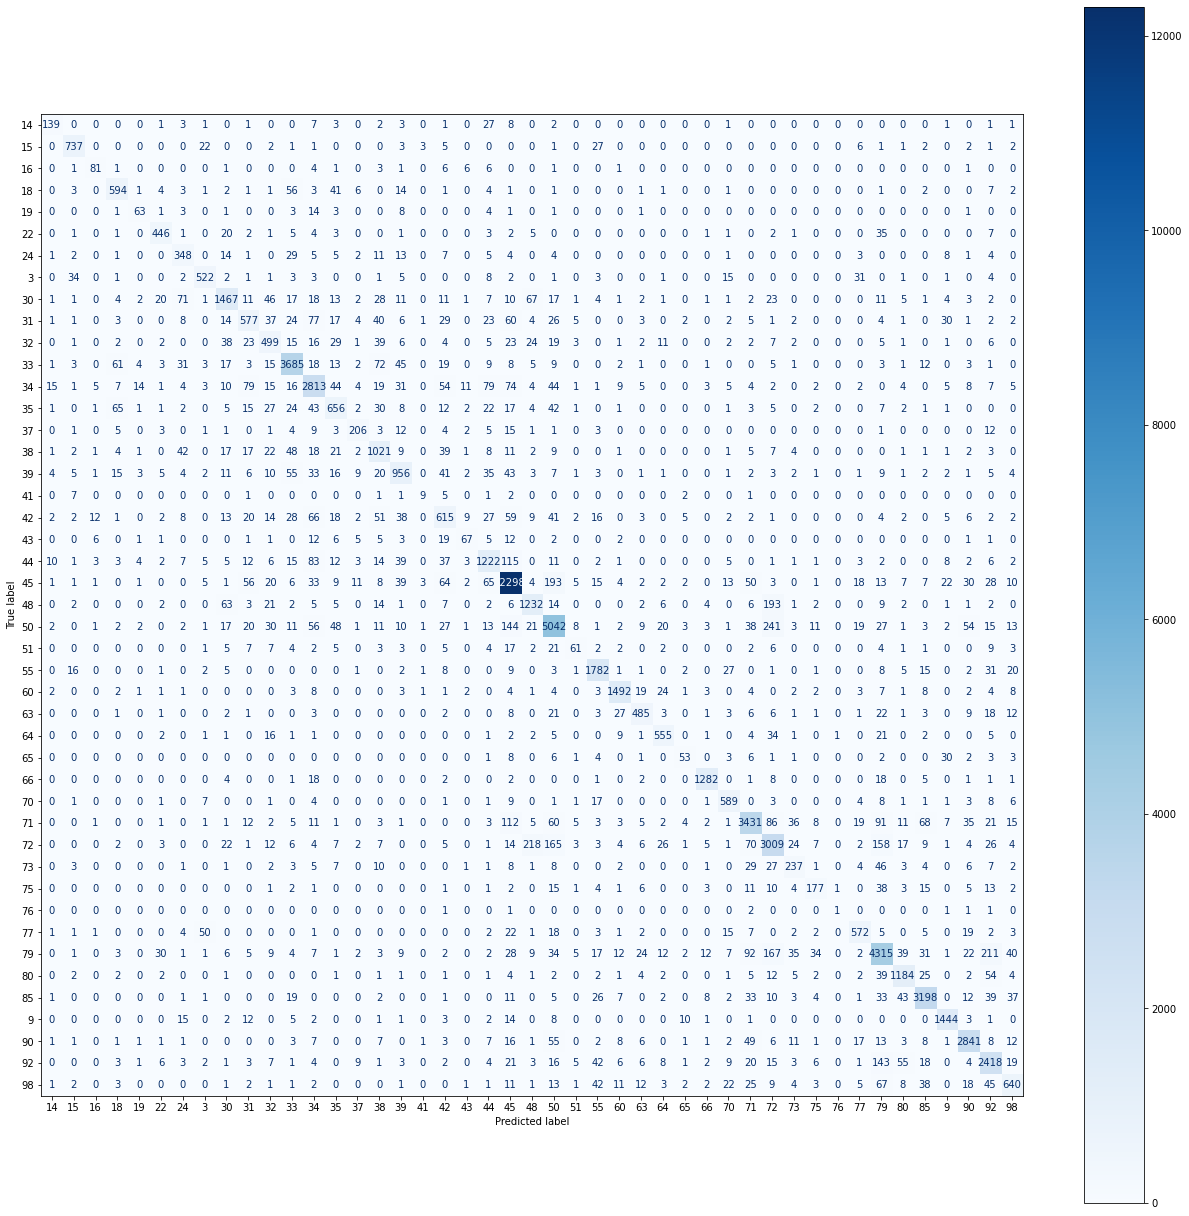

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Finally, let's try the examples again:
test = clf_GS_SVM.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

array(['3', '55', '45', '30', '45', '45'], dtype=object)

##SGDClassifier

In [ ]:
#Model and hyperparameters
parametersSGD = { 
                 'SGD__max_iter':[300, 500, 1000, 1500],
                 'SGD__loss':['modified_huber',]
                 }
modelSGD = SGDClassifier(loss= 'perceptron', 
                         penalty= 'l2',
                         max_iter= 1000, 
                         n_jobs= -1,
                         class_weight= 'balanced',
                         learning_rate= 'optimal',  
                         early_stopping= True,
                         random_state=42, verbose=2)

In [ ]:
#Model
clf_SGD = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                    ngram_range = (1,3),
                                    tokenizer=word_tokenize,
                                    strip_accents='ascii',
                                    max_features=None,
                                    lowercase=True)),
    ('SGD', modelSGD)
])

clf_GS_SGD = GridSearchCV(clf_SGD, parametersSGD, cv=2, n_jobs=-1, verbose=3)
clf_GS_SGD.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 147.48, NNZs: 70182, Bias: -20.261762, T: 278779, Avg. loss: 3.041154
Total training time: 0.40 seconds.
Norm: 68.92, NNZs: 60669, Bias: -10.456951, T: 278779, Avg. loss: 0.666833
Total training time: 0.44 seconds.
-- Epoch 2
-- Epoch 2
Norm: 87.77, NNZs: 81680, Bias: -19.785058, T: 557558, Avg. loss: 0.062305
Total training time: 0.89 seconds.
Norm: 43.69, NNZs: 72972, Bias: -10.017321, T: 557558, Avg. loss: 0.033156
Total training time: 0.94 seconds.
-- Epoch 3
-- Epoch 3
Norm: 66.95, NNZs: 87722, Bias: -19.478210, T: 836337, Avg. loss: 0.027734
Total training time: 1.40 seconds.
Norm: 36.11, NNZs: 81817, Bias: -9.724292, T: 836337, Avg. loss: 0.021113
Total training time: 1.47 seconds.
-- Epoch 4
-- Epoch 4
Norm: 57.27, NNZs: 93353, Bias: -19.234292, T: 1115116, Avg. loss: 0.016218
Total training time: 1.91 seconds.
Norm: 31.86, NNZs: 87698, Bias: -9.525103, T: 1115116, Avg. loss: 0.014237
Total training time: 1.97 seconds.
-- Epoch 5
-- Epoch 5
Norm: 51.

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


-- Epoch 5
-- Epoch 1
Norm: 37.68, NNZs: 132050, Bias: -10.578649, T: 1393895, Avg. loss: 0.017048
Total training time: 3.57 seconds.Norm: 64.33, NNZs: 251068, Bias: -7.939261, T: 278779, Avg. loss: 3.039470

Total training time: 0.42 seconds.
-- Epoch 6
-- Epoch 2
Norm: 35.75, NNZs: 137056, Bias: -10.407221, T: 1672674, Avg. loss: 0.015196
Total training time: 4.10 seconds.
Norm: 45.23, NNZs: 312486, Bias: -6.849414, T: 557558, Avg. loss: 0.380285
Total training time: 0.96 seconds.
Convergence after 6 epochs took 4.25 seconds
-- Epoch 3
-- Epoch 1
Norm: 68.98, NNZs: 96375, Bias: -7.937514, T: 278779, Avg. loss: 1.043148
Total training time: 0.35 seconds.
Norm: 38.13, NNZs: 352875, Bias: -6.193561, T: 836337, Avg. loss: 0.230690
Total training time: 1.62 seconds.
-- Epoch 2
-- Epoch 4
Norm: 45.85, NNZs: 123709, Bias: -7.320554, T: 557558, Avg. loss: 0.065302
Total training time: 0.85 seconds.
Norm: 34.00, NNZs: 383700, Bias: -5.751771, T: 1115116, Avg. loss: 0.168664
Total training tim

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 3),
                                                        strip_accents='ascii',
                                                        tokenizer=<function word_tokenize at 0x7fe165f863b0>)),
                                       ('SGD',
                                        SGDClassifier(class_weight='balanced',
                                                      early_stopping=True,
                                                      loss='perceptron',
                                                      n_jobs=-1,
                                                      random_state=42,
                                                      verbose=2))]),
             n_jobs=-1,
             param_grid={'SGD__loss': ['modified_huber'],
                         'SGD__max_iter': [300, 500, 1000, 1500]},
             verbose=3)

In [ ]:
#Model predictions
y_pred = clf_GS_SGD.predict(X_test)

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SGD__loss': 'modified_huber', 'SGD__max_iter': 300}

Grid scores on testing set:

0.759 (+/-0.007) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 300}
0.759 (+/-0.007) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 500}
0.759 (+/-0.007) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 1000}
0.759 (+/-0.007) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 1500}

best score:  0.7591354563733244

Grid times on testing set:

156.656 seconds (+/-0.905) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 300}
147.669 seconds (+/-4.940) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 500}
147.345 seconds (+/-3.515) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 1000}
142.438 seconds (+/-3.479) for {'SGD__loss': 'modified_huber', 'SGD__max_iter': 1500}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accurac

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SGD__loss': 'perceptron', 'SGD__max_iter': 300}

Grid scores on testing set:

nan (+/-nan) for {'SGD__loss': 'log_loss', 'SGD__max_iter': 300}
nan (+/-nan) for {'SGD__loss': 'log_loss', 'SGD__max_iter': 500}
nan (+/-nan) for {'SGD__loss': 'log_loss', 'SGD__max_iter': 1000}
nan (+/-nan) for {'SGD__loss': 'log_loss', 'SGD__max_iter': 1500}
0.748 (+/-0.016) for {'SGD__loss': 'squared_hinge', 'SGD__max_iter': 300}
0.748 (+/-0.016) for {'SGD__loss': 'squared_hinge', 'SGD__max_iter': 500}
0.748 (+/-0.016) for {'SGD__loss': 'squared_hinge', 'SGD__max_iter': 1000}
0.748 (+/-0.016) for {'SGD__loss': 'squared_hinge', 'SGD__max_iter': 1500}
0.753 (+/-0.018) for {'SGD__loss': 'perceptron', 'SGD__max_iter': 300}
0.753 (+/-0.018) for {'SGD__loss': 'perceptron', 'SGD__max_iter': 500}
0.753 (+/-0.018) for {'SGD__loss': 'perceptron', 'SGD__max_iter': 1000}
0.753 (+/-0.018) for {'SGD__loss': 'perceptron', 'SGD__max_iter': 1500}

best score:

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300, 'SGD__penalty': 'l2'}

Grid scores on testing set:

0.753 (+/-0.018) for {'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300, 'SGD__penalty': 'l2'}
nan (+/-nan) for {'SGD__learning_rate': 'adaptive', 'SGD__max_iter': 300, 'SGD__penalty': 'l2'}

best score:  0.7527594680704015

Grid times on testing set:

167.235 seconds (+/-2.757) for {'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300, 'SGD__penalty': 'l2'}
74.876 seconds (+/-0.459) for {'SGD__learning_rate': 'adaptive', 'SGD__max_iter': 300, 'SGD__penalty': 'l2'}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.6538754894619998, 'accuracy': 0.7789615051847261}
              precision    recall  f1-score   support

          14       0.87      0.54      0.67       202
          15       0.89      0.79   

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'SGD__class_weight': 'balanced', 'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300}

Grid scores on testing set:

0.753 (+/-0.018) for {'SGD__class_weight': 'balanced', 'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300}
0.744 (+/-0.010) for {'SGD__class_weight': None, 'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300}

best score:  0.7527594680704015

Grid times on testing set:

144.022 seconds (+/-3.356) for {'SGD__class_weight': 'balanced', 'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300}
141.442 seconds (+/-2.952) for {'SGD__class_weight': None, 'SGD__learning_rate': 'optimal', 'SGD__max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.6538754894619998, 'accuracy': 0.7789615051847261}
              precision    recall  f1-score   support

          14       0.87      0.54      0.67 

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##RandomForest

In [ ]:
modelRF = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1, verbose=3)

In [ ]:
#Model
clf_RF = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                    tokenizer=word_tokenize,
                                    strip_accents='ascii',
                                    max_features=None,
                                    lowercase=True)),
    ('RF', modelRF)
])
clf_RF.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 59.5min


building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 106.0min finished


Pipeline(steps=[('vectorizer',
                 CountVectorizer(strip_accents='ascii',
                                 tokenizer=<function word_tokenize at 0x7f25c8fd93b0>)),
                ('RF',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42, verbose=3))])

In [ ]:
# Let's see the results
y_pred = clf_RF.predict(X_test)
y_pred

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    7.6s finished


array(['64', '85', '50', ..., '79', '85', '31'], dtype=object)

In [ ]:
print(multi_label_metrics(y_test, y_pred))

{'balanced_accuracy_score': 0.6368653767600583, 'accuracy': 0.7867224525110087}


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          14       0.80      0.56      0.66       202
          15       0.86      0.86      0.86       817
          16       0.69      0.52      0.59       114
          18       0.74      0.71      0.73       752
          19       0.62      0.47      0.53       105
          22       0.89      0.71      0.79       542
          24       0.57      0.67      0.62       469
           3       0.82      0.74      0.78       642
          30       0.75      0.68      0.72      1888
          31       0.66      0.41      0.50      1012
          32       0.63      0.40      0.49       789
          33       0.77      0.89      0.83      4056
          34       0.70      0.80      0.74      3410
          35       0.70      0.54      0.61      1004
          37       0.84      0.57      0.68       293
          38       0.68      0.65      0.66      1322
          39       0.74      0.57      0.65      1326
          41       0.71    

<Figure size 432x288 with 0 Axes>

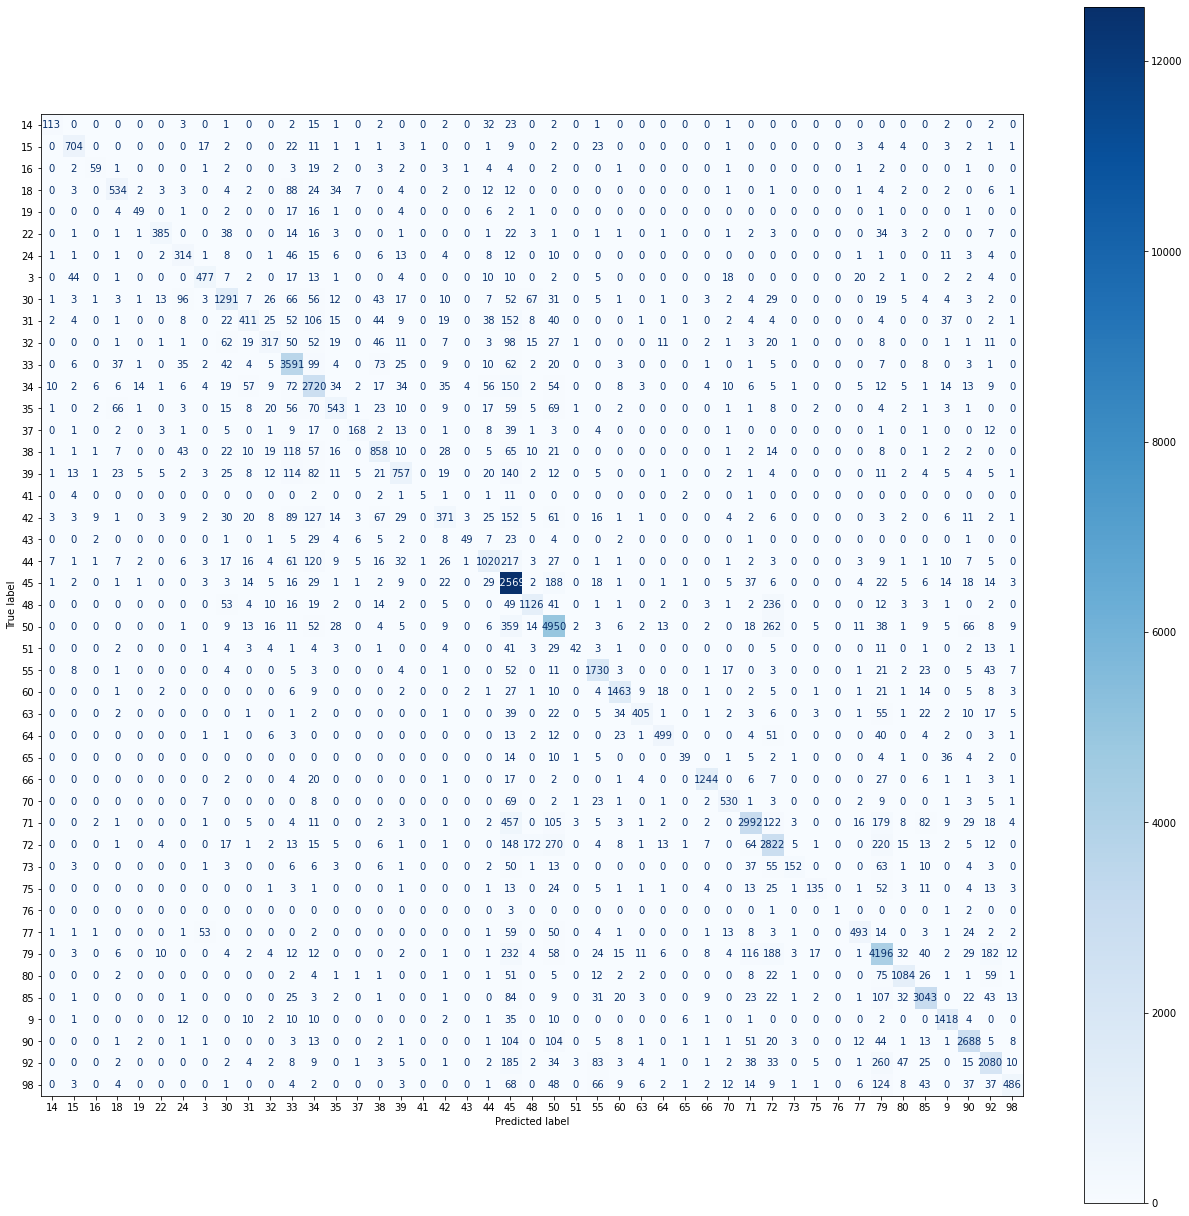

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(22,22))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples again:
test = clf_RF.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


array(['33', '55', '45', '44', '33', '33'], dtype=object)